# Neutral mouse experimental design

In the neutral mouse, we will sparsely sample GC B cells in bulk from lymph nodes. We want to design a sampling procedure that gives us good estimates for the rates of all (or most) possible mutations.

## Assumptions
- We sample $n>>1$ iid sequences from independent lineages, so we don't consider the possibility of shared ancestry of mutations.
- The number of mutations in each sequence of length $\ell$ is a Poisson rv with mean $\lambda << \ell$.
- Each particular mutation event in a sequence occurs at site $i$ and goes to alternative nucleotide $j$ wp $M_{ij}$, where matrix $M\in\mathbb{R}_+^{\ell \times 3}$ represents the mutabilities and substitution biases at each site, normalized such that $\sum_{ij}M_{ij}=1$. Since $\lambda << \ell$, we can neglect multiple hits.

Let rv $X_{ij}\in\mathbb{N}_0$ denote the number of mutations at site $i$ to alternative nt $j$ seen across all $n$ sequences.
Standard results on Poissonization of multinomials give
$$
X_{ij}\sim\text{Pois}(n \lambda M_{ij}).
$$

## Dropout design criterion

Our design objective will be to control the number of vanishing elements of $X_{ij}$ (we need to observe mutation counts to get a point estimate of their rates).
Define the dropout rv $D = \sum_{ij}\mathbf{1}_{0}(X_{ij}).$
Note that $D$ is a [Poisson binomial](https://en.wikipedia.org/wiki/Poisson_binomial_distribution) random variable.

Now,
$$
\mathbb{E}[D] = \sum_{ij}\mathbb{P}(X_{ij}=0) = \sum_{ij}e^{-n \lambda M_{ij}},
$$
and
$$
\text{Var}[D] = \sum_{ij}\left(1-\mathbb{P}(X_{ij}=0)\right)\mathbb{P}(X_{ij}=0) = \sum_{ij}\left(1-e^{-n \lambda M_{ij}}\right)e^{-n \lambda M_{ij}}.
$$

**Note:** it would be better to work with a quantile function for the Poisson binomial instead of mean and variance, but that would require taking discrete Fourier transforms of the characteristic function (how annoying).

Also denote the fraction of dropout sites $\tilde D = \frac{D}{3\ell}$.

## Computations with an empirical mutability model

For the purpose of this design exercise, we will use 5-mer context model (Yaari et al.).

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

import glob
import pickle

In [2]:
mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
mutability

Fivemer
AAAAA    0.000596
AAAAC    0.000865
AAAAG    0.000418
AAAAT    0.000588
AAAAN    0.000617
           ...   
NNTNA    0.000272
NNTNC    0.000398
NNTNG    0.000365
NNTNT    0.000383
NNTNN    0.000354
Name: Mutability, Length: 2500, dtype: float64

In [3]:
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)
substitution

,A,C,G,T
Fivemer,,,,
AAAAA,0.000000,0.168399,0.727651,0.103950
AAAAC,0.000000,0.191268,0.704782,0.103950
AAAAG,0.000000,0.166320,0.723493,0.110187
AAAAT,0.000000,0.090909,0.863636,0.045455
AAAAN,0.000000,0.154224,0.754890,0.090885
...,...,...,...,...
NNTNA,0.276383,0.526126,0.197491,0.000000
NNTNC,0.263436,0.547941,0.188623,0.000000
NNTNG,0.265640,0.540766,0.193594,0.000000


Load a replay tree object, so we can grab the root naive chIgy sequence.

In [4]:
results = "../nextflow/results/latest"
files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"))
tree = pickle.load(open(files[0], "rb"))

Get the concatenated heavy/light chain naive sequence, and split into heavy and light chains.

In [5]:
naive = tree.tree.sequence

# the index of the first light chain base in the concatenated sequence
igk_idx = 336

5-mer contexts for chIgy

In [6]:
padded_igh = "NN" + naive[:igk_idx] + "NN"
padded_igk = "NN" + naive[igk_idx:] + "NN"
# mutabilities of each nucleotide
contexts = [padded_igh[(i - 2) : (i + 3)]
                for i in range(2, len(padded_igh) - 2)
               ] + [padded_igk[(i - 2) : (i + 3)]
                    for i in range(2, len(padded_igk) - 2)
                   ]

Construct $M$ matrix

In [7]:
M = mutability[contexts].values[:, None] * substitution.loc[contexts, :].values

# normalize
M /= M.sum()

# exclude the 0 elements, which represent non-mutation (set then to NaN)
M = np.where(M == 0, np.nan, M)
assert all(np.isnan(M).sum(1) == 1)

Use the formulae above for the expectation and variance of the dropout statistic $D$.

In [8]:
def D_mean_std(n, λ, M):
    p = np.exp(-n * λ * M)
    p_sum = np.nansum(p)
    p_squared_sum = np.nansum(p ** 2)
    return p_sum, np.sqrt(p_sum - p_squared_sum)

Assuming a value for $\lambda$, let's plot the dropout fraction $\tilde D$ over a range of sample sizes $n$.

In [11]:
λ = 2

n_grid = np.logspace(0, 6)

D_mean_grid, D_std_grid = zip(*(D_mean_std(n, λ, M) for n in n_grid))
D_mean_grid = np.array(D_mean_grid)
D_std_grid = np.array(D_std_grid)

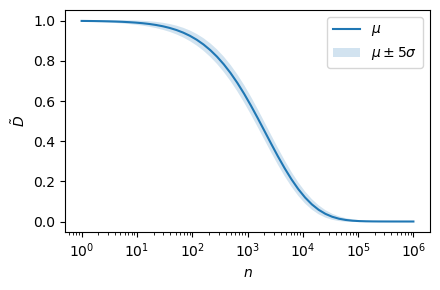

In [15]:
l = M.shape[0] * (M.shape[1] - 1)
n_stds = 5

plt.figure(figsize=(4.5, 3))
plt.plot(n_grid, D_mean_grid / l, label="$\mu$")
plt.fill_between(n_grid, (D_mean_grid - n_stds * D_std_grid) / l, (D_mean_grid + n_stds * D_std_grid) / l, alpha=0.2, label=f"$\mu\pm {n_stds} \sigma$")
plt.xscale("log")
plt.legend()
plt.xlabel("$n$")
plt.ylabel(r"$\tilde D$")
plt.tight_layout()
plt.show()